In [ ]:
import torch
import torch.nn.functional as F
from torch import nn

In [ ]:
rng = torch.distributions.MultivariateNormal(torch.zeros(1024), 0.01*torch.eye(1024))
x_data = rng.sample((1000,))

In [ ]:
x_data

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(784, 512), nn.ReLU(), nn.Linear(512, 256))
        self.dec = nn.Sequential(nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, 784))
        
    def forward(self, x):
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        return x_enc, x_dec
    
    def encoder(self, x):
        x = self.enc(x)
        return x
    
    def decoder(self, x):
        x = self.dec(x)
        return x
    

# WAE

In [6]:
import torch
import torch.nn.functional as F
from torch import nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from torchvision.datasets import CIFAR10, MNIST, FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Lambda
from torchvision.utils import make_grid
from torch.utils.data import Subset

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



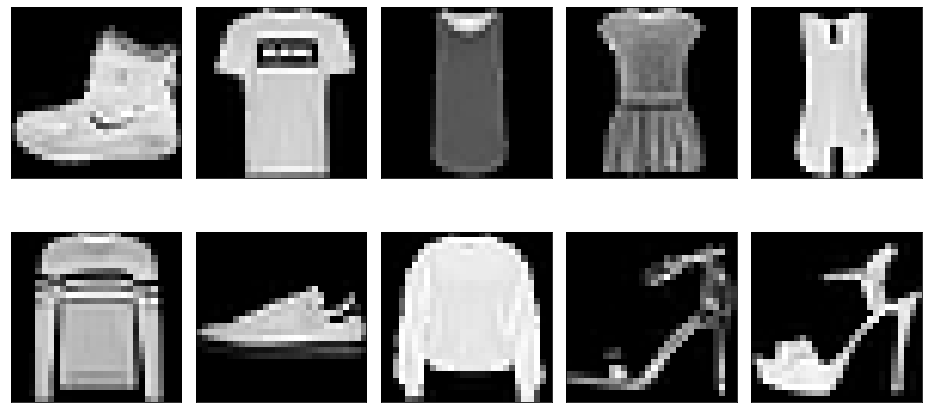

In [7]:
def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28*28) / 255.
    _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().to(device) / 255.)
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())
        
        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap='gray')
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())
    
    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[i].set_xticks(())
            axes[i].set_yticks(())
    
    plt.show()
    
def plot_pca(data, model):
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    plt.figure(figsize=(10, 6))
    pca = PCA(2)

    z = model.encode(train_data.data.view(-1, 784).float().to(device))
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())
    
    for class_idx in range(10):
        indices = (data.targets == class_idx)
        plt.scatter(
            reduced_z[indices, 0], reduced_z[indices, 1],
            s=2., label=labels[class_idx])

    plt.legend()
    plt.show()

def plot_samples(model):
    sampled_z = torch.randn(20, model.latent_dim).to(device)
    generated = model.decode(sampled_z)

    generated = generated.cpu().detach().numpy()
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
        ax.set_xticks(())
        ax.set_yticks(())
    fig.tight_layout()
    fig.suptitle("Generated samples")
    plt.show()
    
    
batch_size = 256
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root='.', 
                          train=True, 
                          transform=transforms,
                          download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = FashionMNIST(root='.', 
                   train=False, 
                   transform=transforms,    
                   download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

fig, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap='gray')
    ax.set_xticks(())
    ax.set_yticks(())
fig.tight_layout()
plt.show()

In [8]:
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded
    
    def mmd_loss(self, y, sigma):
        z = torch.randn(y.size(0), self.latent_dim).to(y.device)

        yy_dist = (y.unsqueeze(0) - y.unsqueeze(1)).square().sum(-1)
        zz_dist = (z.unsqueeze(0) - z.unsqueeze(1)).square().sum(-1)
        yz_dist = (y.unsqueeze(0) - z.unsqueeze(1)).square().sum(-1)


        yy_term = sigma / (sigma + yy_dist)
        zz_term = sigma / (sigma + zz_dist)
        yz_term = sigma / (sigma + yz_dist)

        return (yy_term - 2 * yz_term + zz_term).mean()

Epoch: 0  |  train loss: 0.1126  |  test loss: 0.0646


<Figure size 432x288 with 0 Axes>

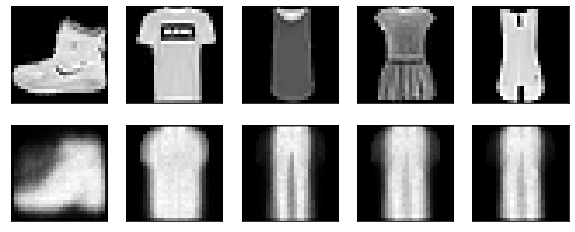

<Figure size 432x288 with 0 Axes>

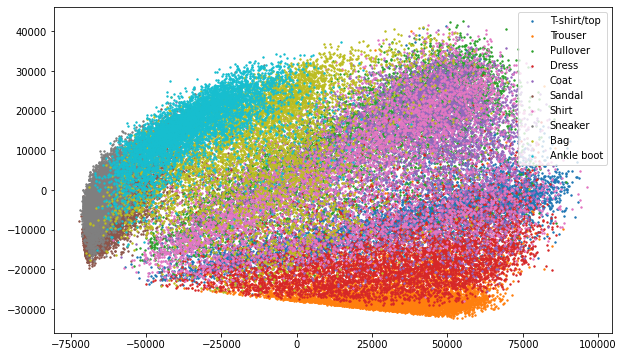

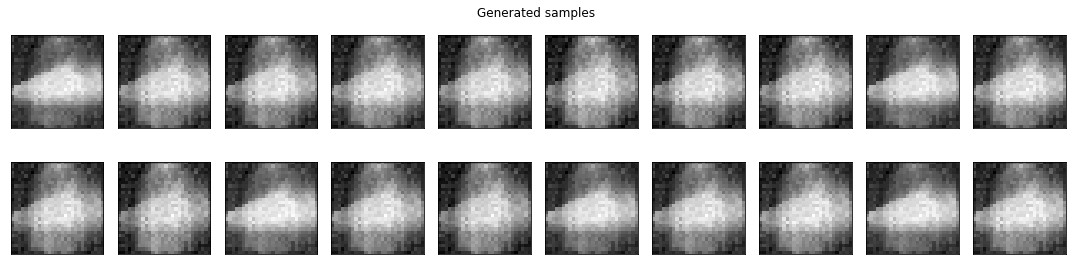

Epoch: 1  |  train loss: 0.0565  |  test loss: 0.0538
Epoch: 2  |  train loss: 0.0469  |  test loss: 0.0446
Epoch: 3  |  train loss: 0.0399  |  test loss: 0.0414
Epoch: 4  |  train loss: 0.0368  |  test loss: 0.0381
Epoch: 5  |  train loss: 0.0334  |  test loss: 0.0353
Epoch: 6  |  train loss: 0.0311  |  test loss: 0.0329
Epoch: 7  |  train loss: 0.0294  |  test loss: 0.0318
Epoch: 8  |  train loss: 0.0281  |  test loss: 0.0308
Epoch: 9  |  train loss: 0.0271  |  test loss: 0.0300
Epoch: 10  |  train loss: 0.0264  |  test loss: 0.0294


<Figure size 432x288 with 0 Axes>

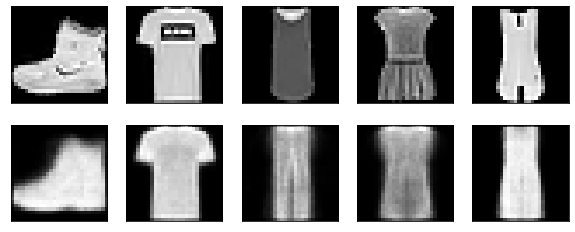

<Figure size 432x288 with 0 Axes>

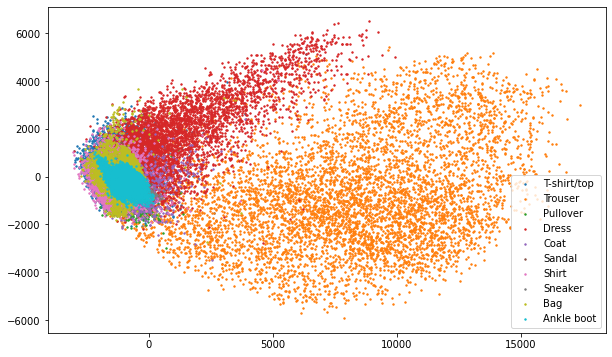

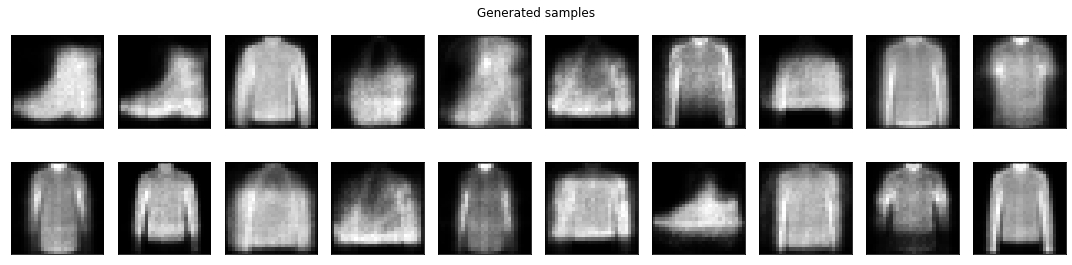

Epoch: 11  |  train loss: 0.0256  |  test loss: 0.0284
Epoch: 12  |  train loss: 0.0252  |  test loss: 0.0300
Epoch: 13  |  train loss: 0.0247  |  test loss: 0.0276
Epoch: 14  |  train loss: 0.0242  |  test loss: 0.0270
Epoch: 15  |  train loss: 0.0237  |  test loss: 0.0271
Epoch: 16  |  train loss: 0.0233  |  test loss: 0.0266
Epoch: 17  |  train loss: 0.0230  |  test loss: 0.0261
Epoch: 18  |  train loss: 0.0227  |  test loss: 0.0258
Epoch: 19  |  train loss: 0.0224  |  test loss: 0.0256
Epoch: 20  |  train loss: 0.0221  |  test loss: 0.0254


<Figure size 432x288 with 0 Axes>

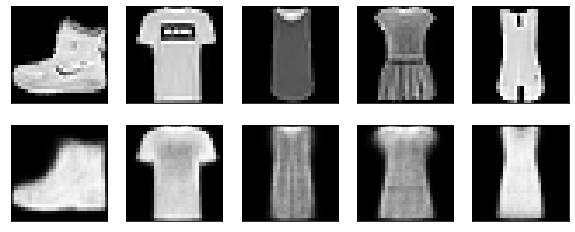

<Figure size 432x288 with 0 Axes>

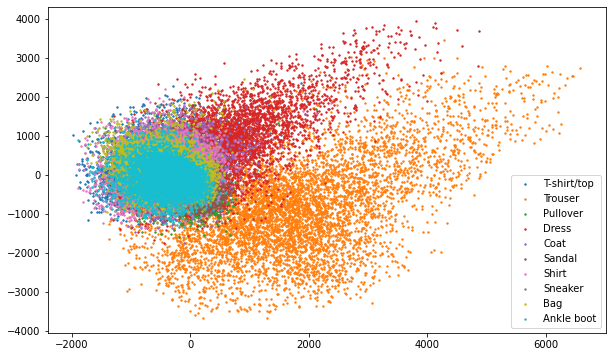

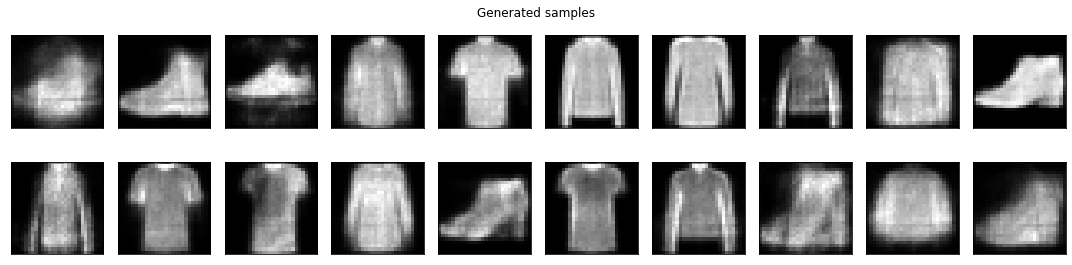

Epoch: 21  |  train loss: 0.0219  |  test loss: 0.0255
Epoch: 22  |  train loss: 0.0218  |  test loss: 0.0254
Epoch: 23  |  train loss: 0.0216  |  test loss: 0.0249
Epoch: 24  |  train loss: 0.0214  |  test loss: 0.0248
Epoch: 25  |  train loss: 0.0213  |  test loss: 0.0244
Epoch: 26  |  train loss: 0.0210  |  test loss: 0.0242
Epoch: 27  |  train loss: 0.0209  |  test loss: 0.0241
Epoch: 28  |  train loss: 0.0206  |  test loss: 0.0239
Epoch: 29  |  train loss: 0.0205  |  test loss: 0.0239
Epoch: 30  |  train loss: 0.0203  |  test loss: 0.0237


<Figure size 432x288 with 0 Axes>

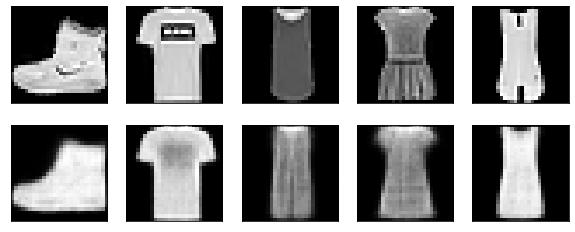

<Figure size 432x288 with 0 Axes>

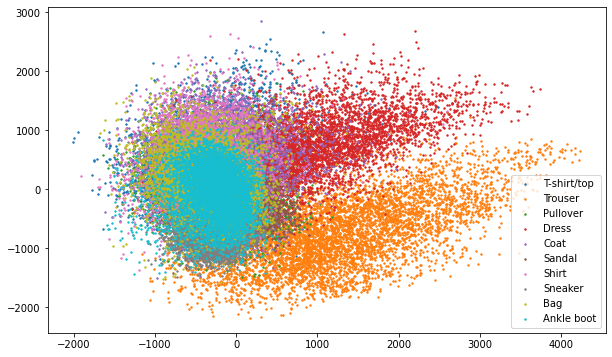

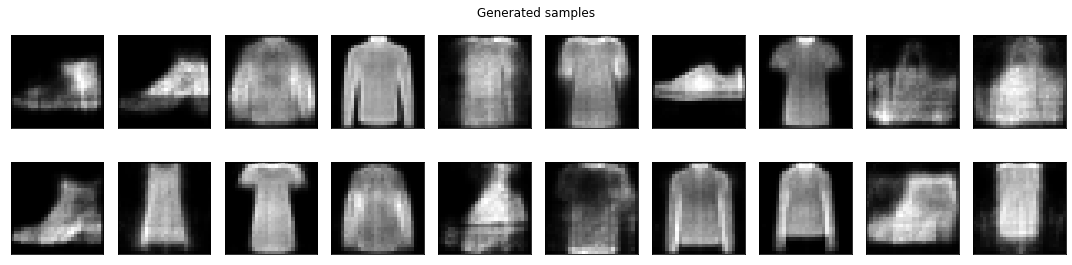

Epoch: 31  |  train loss: 0.0201  |  test loss: 0.0235
Epoch: 32  |  train loss: 0.0199  |  test loss: 0.0233
Epoch: 33  |  train loss: 0.0199  |  test loss: 0.0232
Epoch: 34  |  train loss: 0.0197  |  test loss: 0.0231
Epoch: 35  |  train loss: 0.0196  |  test loss: 0.0235
Epoch: 36  |  train loss: 0.0195  |  test loss: 0.0228
Epoch: 37  |  train loss: 0.0194  |  test loss: 0.0229
Epoch: 38  |  train loss: 0.0194  |  test loss: 0.0227
Epoch: 39  |  train loss: 0.0192  |  test loss: 0.0227
Epoch: 40  |  train loss: 0.0191  |  test loss: 0.0225


<Figure size 432x288 with 0 Axes>

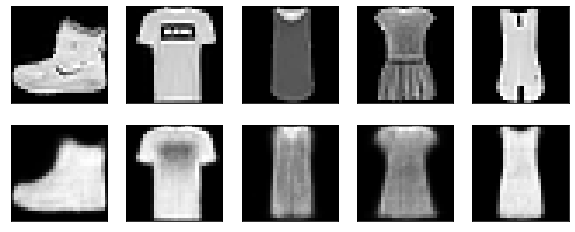

<Figure size 432x288 with 0 Axes>

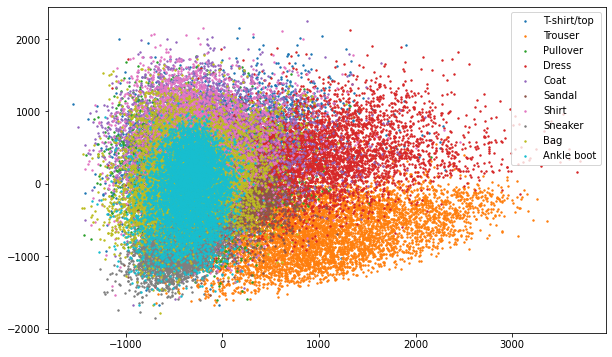

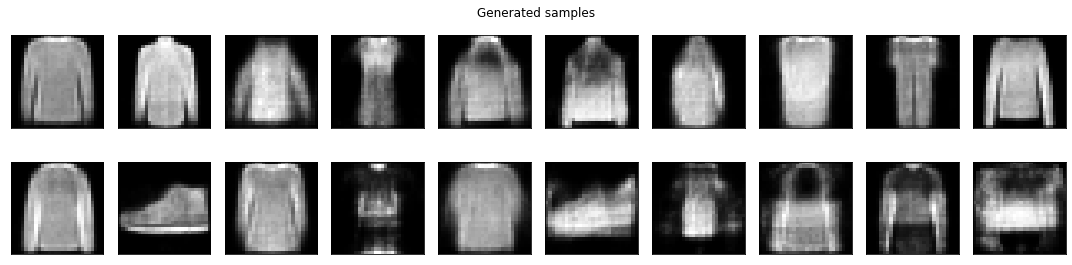

Epoch: 41  |  train loss: 0.0190  |  test loss: 0.0226
Epoch: 42  |  train loss: 0.0189  |  test loss: 0.0226
Epoch: 43  |  train loss: 0.0188  |  test loss: 0.0224
Epoch: 44  |  train loss: 0.0188  |  test loss: 0.0222
Epoch: 45  |  train loss: 0.0187  |  test loss: 0.0221
Epoch: 46  |  train loss: 0.0186  |  test loss: 0.0221
Epoch: 47  |  train loss: 0.0186  |  test loss: 0.0225
Epoch: 48  |  train loss: 0.0184  |  test loss: 0.0220
Epoch: 49  |  train loss: 0.0184  |  test loss: 0.0224
Epoch: 50  |  train loss: 0.0184  |  test loss: 0.0221


<Figure size 432x288 with 0 Axes>

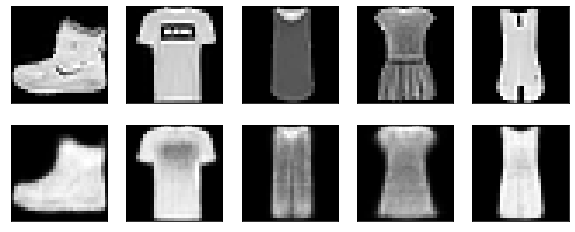

<Figure size 432x288 with 0 Axes>

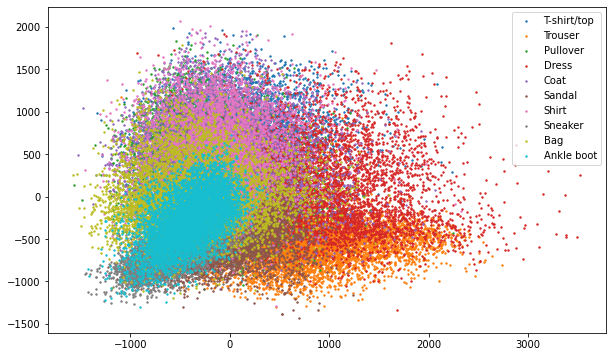

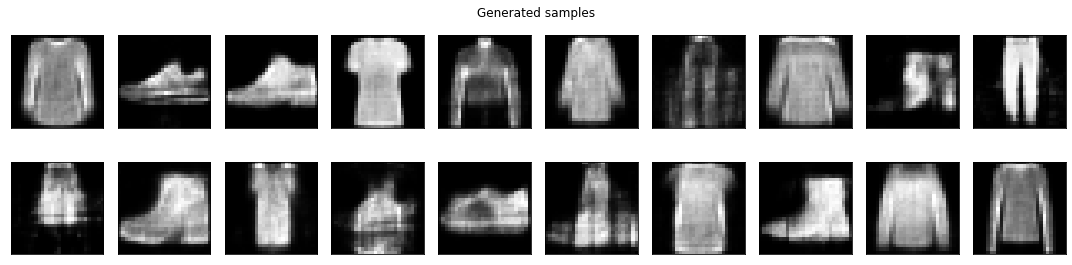

Epoch: 51  |  train loss: 0.0183  |  test loss: 0.0220
Epoch: 52  |  train loss: 0.0182  |  test loss: 0.0221
Epoch: 53  |  train loss: 0.0181  |  test loss: 0.0218
Epoch: 54  |  train loss: 0.0181  |  test loss: 0.0217
Epoch: 55  |  train loss: 0.0181  |  test loss: 0.0219
Epoch: 56  |  train loss: 0.0180  |  test loss: 0.0216
Epoch: 57  |  train loss: 0.0179  |  test loss: 0.0217
Epoch: 58  |  train loss: 0.0179  |  test loss: 0.0215
Epoch: 59  |  train loss: 0.0178  |  test loss: 0.0214
Epoch: 60  |  train loss: 0.0178  |  test loss: 0.0216


<Figure size 432x288 with 0 Axes>

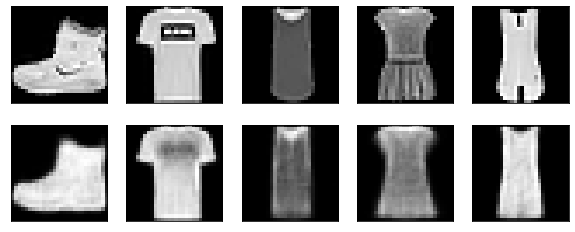

<Figure size 432x288 with 0 Axes>

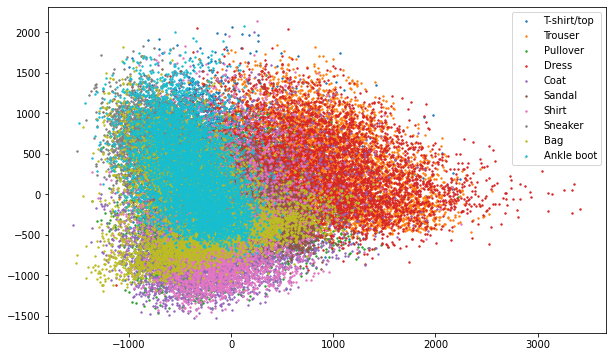

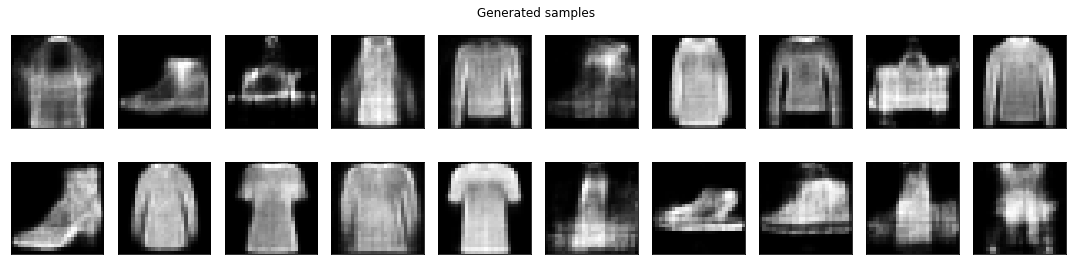

Epoch: 61  |  train loss: 0.0177  |  test loss: 0.0216
Epoch: 62  |  train loss: 0.0177  |  test loss: 0.0215
Epoch: 63  |  train loss: 0.0176  |  test loss: 0.0213
Epoch: 64  |  train loss: 0.0176  |  test loss: 0.0213
Epoch: 65  |  train loss: 0.0175  |  test loss: 0.0214
Epoch: 66  |  train loss: 0.0175  |  test loss: 0.0212
Epoch: 67  |  train loss: 0.0174  |  test loss: 0.0212
Epoch: 68  |  train loss: 0.0174  |  test loss: 0.0212
Epoch: 69  |  train loss: 0.0174  |  test loss: 0.0210
Epoch: 70  |  train loss: 0.0173  |  test loss: 0.0211


<Figure size 432x288 with 0 Axes>

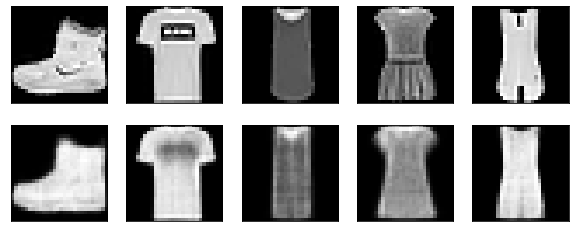

<Figure size 432x288 with 0 Axes>

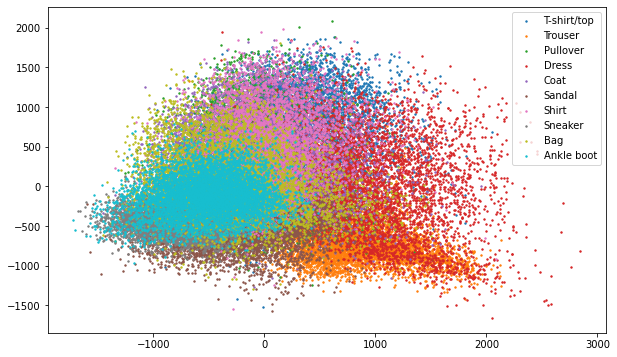

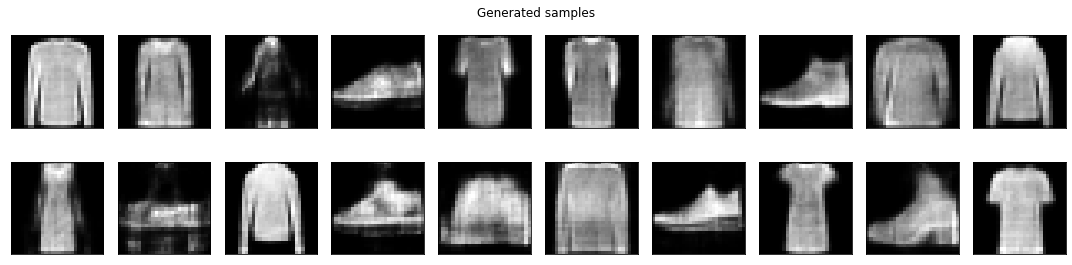

Epoch: 71  |  train loss: 0.0173  |  test loss: 0.0210
Epoch: 72  |  train loss: 0.0172  |  test loss: 0.0211
Epoch: 73  |  train loss: 0.0172  |  test loss: 0.0210
Epoch: 74  |  train loss: 0.0171  |  test loss: 0.0210
Epoch: 75  |  train loss: 0.0171  |  test loss: 0.0209
Epoch: 76  |  train loss: 0.0171  |  test loss: 0.0209
Epoch: 77  |  train loss: 0.0170  |  test loss: 0.0209
Epoch: 78  |  train loss: 0.0170  |  test loss: 0.0208
Epoch: 79  |  train loss: 0.0170  |  test loss: 0.0208
Epoch: 80  |  train loss: 0.0169  |  test loss: 0.0208


<Figure size 432x288 with 0 Axes>

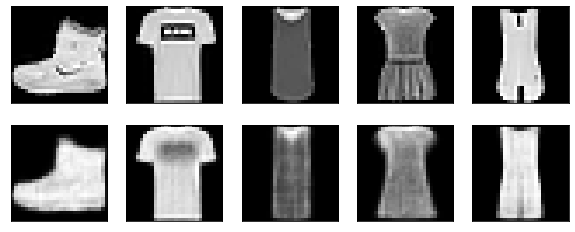

<Figure size 432x288 with 0 Axes>

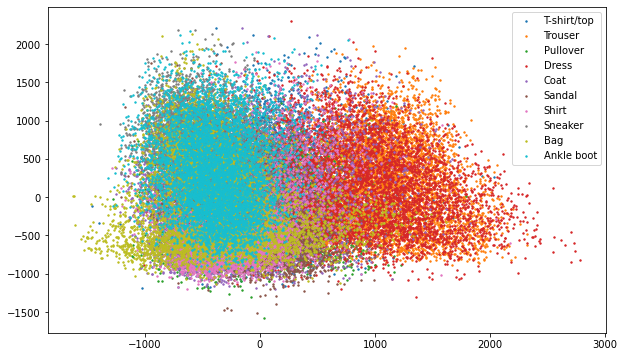

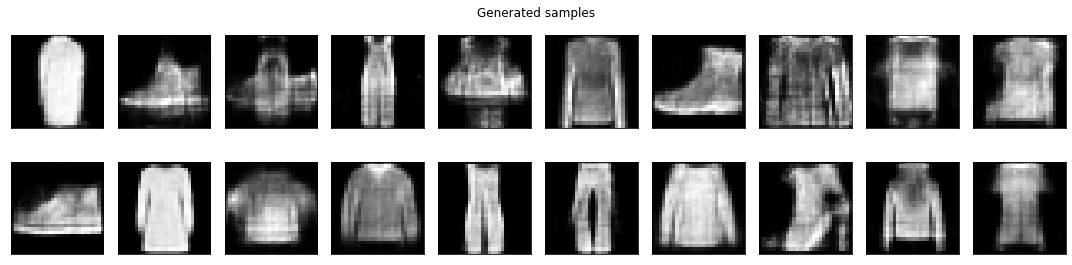

Epoch: 81  |  train loss: 0.0169  |  test loss: 0.0207
Epoch: 82  |  train loss: 0.0169  |  test loss: 0.0206
Epoch: 83  |  train loss: 0.0168  |  test loss: 0.0208
Epoch: 84  |  train loss: 0.0168  |  test loss: 0.0206
Epoch: 85  |  train loss: 0.0168  |  test loss: 0.0206
Epoch: 86  |  train loss: 0.0167  |  test loss: 0.0206
Epoch: 87  |  train loss: 0.0167  |  test loss: 0.0205
Epoch: 88  |  train loss: 0.0167  |  test loss: 0.0207
Epoch: 89  |  train loss: 0.0166  |  test loss: 0.0204
Epoch: 90  |  train loss: 0.0166  |  test loss: 0.0205


<Figure size 432x288 with 0 Axes>

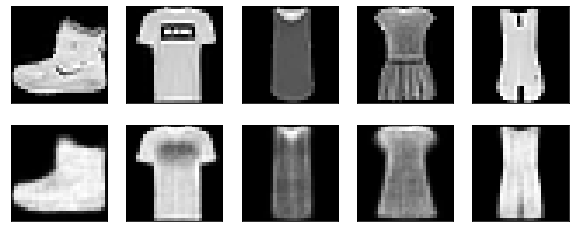

<Figure size 432x288 with 0 Axes>

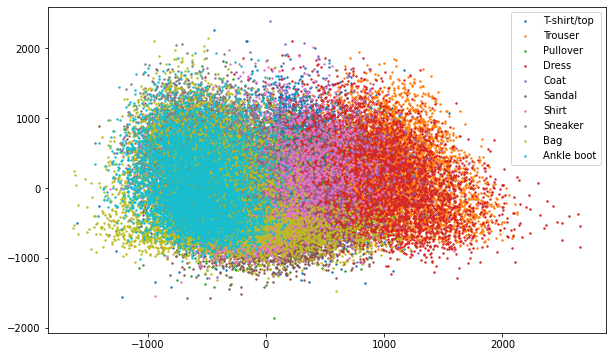

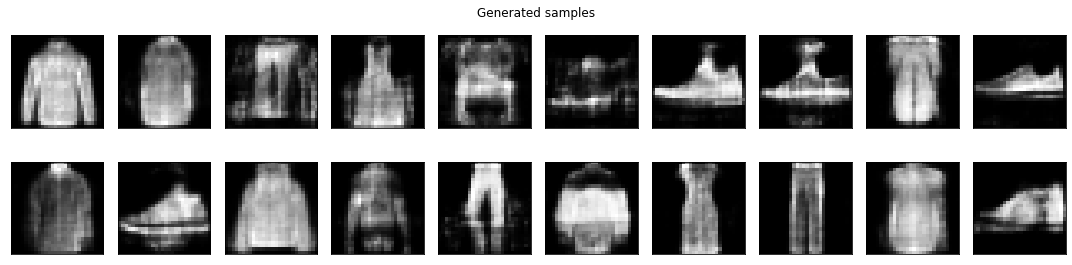

Epoch: 91  |  train loss: 0.0166  |  test loss: 0.0207
Epoch: 92  |  train loss: 0.0166  |  test loss: 0.0205
Epoch: 93  |  train loss: 0.0165  |  test loss: 0.0204
Epoch: 94  |  train loss: 0.0165  |  test loss: 0.0209
Epoch: 95  |  train loss: 0.0165  |  test loss: 0.0204
Epoch: 96  |  train loss: 0.0165  |  test loss: 0.0204
Epoch: 97  |  train loss: 0.0164  |  test loss: 0.0203
Epoch: 98  |  train loss: 0.0164  |  test loss: 0.0205
Epoch: 99  |  train loss: 0.0164  |  test loss: 0.0204
Epoch: 100  |  train loss: 0.0164  |  test loss: 0.0203


<Figure size 432x288 with 0 Axes>

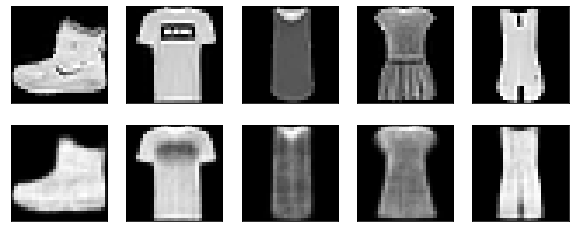

<Figure size 432x288 with 0 Axes>

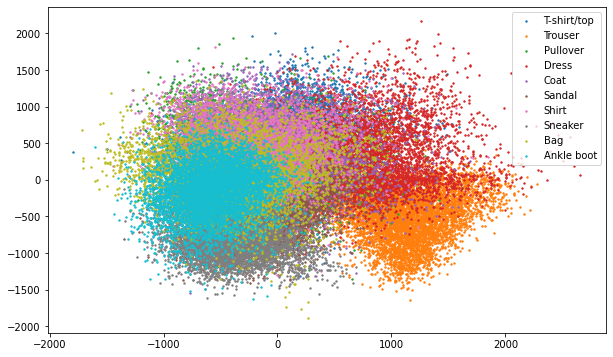

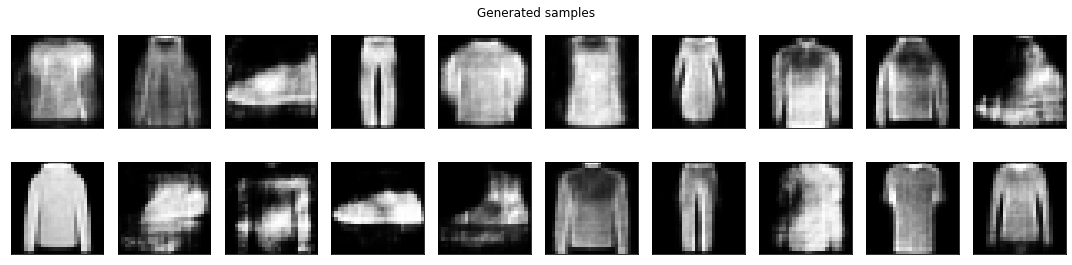

In [11]:
import madgrad
import numpy as np

n_epochs = 101
lr = 5e-3
latent_dim = 50

wae = WAEMMD(latent_dim).to(device)

optimizer_wae = madgrad.MADGRAD(wae.parameters(), lr=lr)
criterion_1 = torch.nn.MSELoss().to(device)

sigma = 2 * latent_dim * 0.01
C = 1.0

for epoch in range(n_epochs):
    epoch_losses_train = []
    for step, (x, _) in enumerate(train_loader):
        x = x.to(device)
        encoded, decoded = wae(x)
        rec_loss = criterion_1(decoded, x)
        latent_loss = wae.mmd_loss(encoded, sigma)
        loss = rec_loss + C * latent_loss
        optimizer_wae.zero_grad()
        loss.backward()
        optimizer_wae.step()

        epoch_losses_train += [loss.item()]
        
    epoch_losses_test = []  
    for step, (x, _) in enumerate(test_loader):
        x = x.to(device)       
        encoded, decoded = wae(x)
        rec_loss = criterion_1(decoded, x)
        latent_loss = wae.mmd_loss(encoded, sigma)
        loss = rec_loss + C * latent_loss           
        epoch_losses_test.append(loss.item())

    print(f'Epoch: {epoch}  |  train loss: {np.mean(epoch_losses_train):.4f}  |  test loss: {np.mean(epoch_losses_test):.4f}')

    if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)